# DCFS
Working with the DCFS dataset.
###### Nils Dyck, 31.05.2023

## DCFS-DCFS

In [90]:
import pandas as pd

data = pd.read_csv('../data/cleaned/DCFS-DCFS_m2.csv', sep=';')
data = data.loc[data['Year']<2022]
data.shape

(995, 6)

In [91]:
# The total number of papers.
dcfs_m = data.drop_duplicates(subset='Title')
dcfs_titles = dcfs_m['Title'].to_list()
dcfs_authors = data['Author'].to_list()
dcfs_co_authors = data['Co-Authors'].to_list()
no_authors = dcfs_m['No Authors'].to_list()
print('Papers: '+str(len(set(dcfs_titles))))
print('Authors: '+str(len(set(dcfs_authors))))

paper_author_list = [0 for i in range(100)]
papers_per_author = []

for author in set(dcfs_authors):
    res = dcfs_authors.count(author)
    papers_per_author.append(res)
    paper_author_list[res] += 1

mean = sum(papers_per_author)/len(papers_per_author)
print('Papers per author: '+str(mean))

Papers: 467
Authors: 419
Papers per author: 2.3747016706443915


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


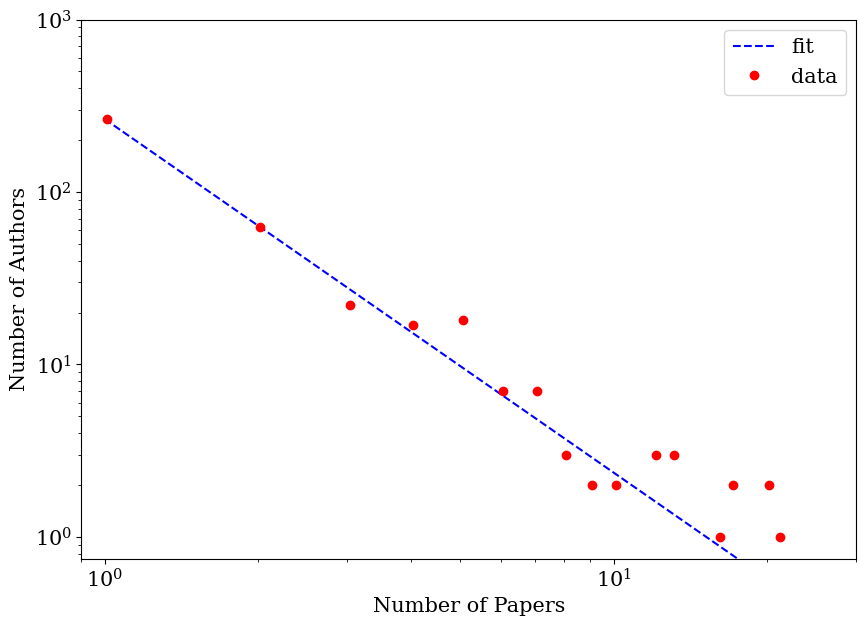

In [92]:
import matplotlib.pyplot as plt, numpy as np, math
from scipy.optimize import curve_fit

plt.figure(figsize=(10,7))
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=15)

# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Initiate data
x = np.linspace(0,100,100)
y = paper_author_list
x_fit = np.linspace(1,92,91)
y_fit = paper_author_list[1:-8]

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, x_fit, y_fit)

# Plot the fitted power-law curve
y_fit = power_law(x_fit, *popt)
plt.loglog(x_fit, y_fit, '--b', label='fit')

# Plot the data on a log-log scale
plt.loglog(x, y, 'or', label='data')

# Add labels and legend
plt.xlabel('Number of Papers')
plt.ylabel('Number of Authors')
plt.legend()
plt.axis((0.9e0,0.3e2,0.75e0,1e3))

plt.savefig('../../Figures/DCFS_paper_powerlaw.png',bbox_inches='tight')

In [93]:
a = popt[0]
b = popt[1]
print(a)
print(b)

264.8041438219617
-2.049350512893454


In [94]:
no_authors = dcfs_m['No Authors'].to_list()
mean = sum(no_authors)/len(no_authors)
print('Mean authors per paper: '+str(mean))

Mean authors per paper: 2.126338329764454


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


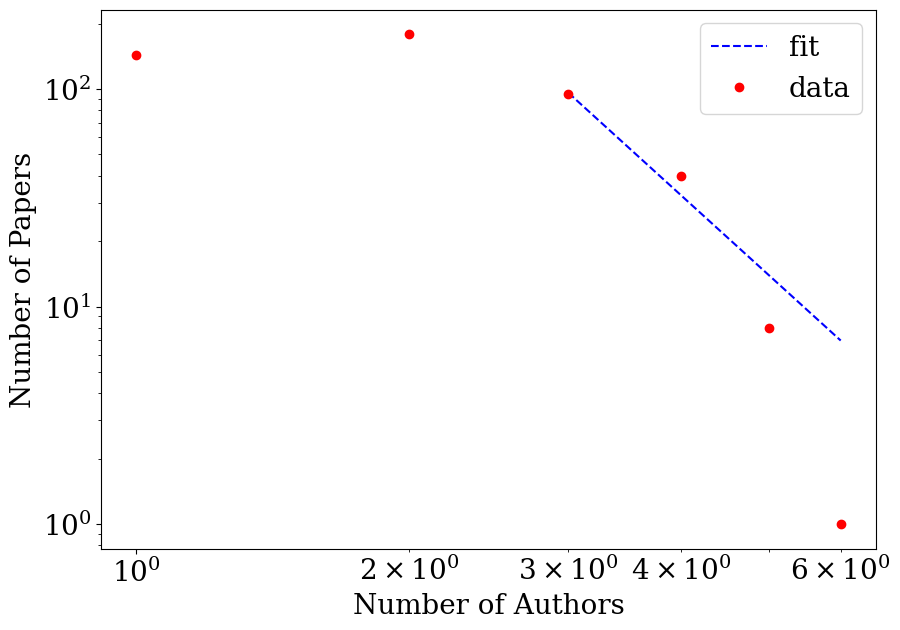

In [95]:
authors_per_paper = [no_authors.count(i) for i in range(1,max(no_authors)+1)]

plt.figure(figsize=(10,7))
plt.rc('font',size=20)

# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Initiate data
x = np.linspace(1,6,6)
y = authors_per_paper
x_fit = np.linspace(3,6,4)
y_fit = authors_per_paper[2:]

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, x_fit, y_fit)

# Plot the fitted power-law curve
y_fit = power_law(x_fit, *popt)
plt.loglog(x_fit, y_fit, '--b', label='fit')

# Plot the data on a log-log scale
plt.loglog(x, y, 'or', label='data')

# Add labels and legend
plt.xlabel('Number of Authors')
plt.ylabel('Number of Papers')
plt.legend()
#plt.axis((0.9e0,0.3e2,0.75e0,1e3))

plt.savefig('../../Figures/DCFS_author_powerlaw.png',bbox_inches='tight')

In [96]:
popt[1]

-3.786740050410926

### Rankings

In [97]:
df = pd.read_csv('../data/cleaned/DCFS-DCFS.csv',sep=';')
df = df.loc[df['Year']<2022]
dfm = data
everyone = df['Author-URL'].to_list()
authors = set(everyone)

In [98]:
def get_name(url):
    name = df.loc[df['Author-URL']==url]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
    return name

paper_ranking = {}
fractional_ranking = {}
co_worker_ranking = {}
collaboration_weight = {}
collaboration_weight_urls = {}
for author in authors:
    papers = everyone.count(author)
    name = df.loc[df['Author-URL']==author]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')    
    paper_ranking[name] = papers
    papers = df.loc[df['Author-URL']==author]
    co_authors = papers['Co-Author-URLs'].to_list()
    fraction = 0
    co_workers = []
    for l in co_authors:
        l = l.replace('[','').replace(']','').replace('"','').replace("'",'') 
        l = l.split(', ')
        for i in l:
            if i != '':
                if collaboration_weight.get((name,get_name(i))):
                    collaboration_weight[(name,get_name(i))] += 1
                    collaboration_weight_urls[(author,i)] += 1
                else:
                    collaboration_weight[(name,get_name(i))] = 1
                    collaboration_weight_urls[(author,i)] = 1
        fraction += (1/(len(l)+1))
        co_workers += l
    co_workers = set(co_workers)
    co_workers = [entry for entry in co_workers if entry != '']
    co_worker_ranking[name] = len(co_workers)
    fractional_ranking[name] = fraction

paper_ranking_sorted = dict(sorted(paper_ranking.items(), key=lambda item: item[1], reverse=True))
fractional_ranking_sorted = dict(sorted(fractional_ranking.items(), key=lambda item: item[1], reverse=True))
co_worker_ranking_sorted = dict(sorted(co_worker_ranking.items(), key=lambda item: item[1], reverse=True))
collaboration_weight_sorted = dict(sorted(collaboration_weight.items(), key=lambda item: item[1], reverse=True))

#delete duplicates in collaboration weight
keys = list(collaboration_weight_sorted.keys())
control = set(keys)
for key in keys:
    if set(key) in control:
        del collaboration_weight_sorted[(key[1],key[0])]
        control.remove(set(key))

top10_papers = list(paper_ranking_sorted.items())[:10]
top10_fractional = list(fractional_ranking_sorted.items())[:10]
top10_co_workers = list(co_worker_ranking_sorted.items())[:10]
top10_collaboration_weights = list(collaboration_weight_sorted.items())[:22]

In [99]:
collaboration_weight_urls

{('https://dblp.uni-trier.de/pid/45/476.html',
  'https://dblp.uni-trier.de/pid/82/752.html'): 1,
 ('https://dblp.uni-trier.de/pid/45/476.html',
  'https://dblp.uni-trier.de/pid/54/5347.html'): 1,
 ('https://dblp.uni-trier.de/pid/45/476.html',
  'https://dblp.uni-trier.de/pid/88/6877.html'): 1,
 ('https://dblp.uni-trier.de/pid/45/476.html',
  'https://dblp.uni-trier.de/pid/86/4985.html'): 1,
 ('https://dblp.uni-trier.de/pid/09/906.html',
  'https://dblp.uni-trier.de/pid/83/2770.html'): 1,
 ('https://dblp.uni-trier.de/pid/41/4735.html',
  'https://dblp.uni-trier.de/pid/02/6009.html'): 1,
 ('https://dblp.uni-trier.de/pid/41/4735.html',
  'https://dblp.uni-trier.de/pid/93/263.html'): 2,
 ('https://dblp.uni-trier.de/pid/41/4735.html',
  'https://dblp.uni-trier.de/pid/59/3307.html'): 1,
 ('https://dblp.uni-trier.de/pid/41/4735.html',
  'https://dblp.uni-trier.de/pid/s/NicolaeSantean.html'): 1,
 ('https://dblp.uni-trier.de/pid/41/4735.html',
  'https://dblp.uni-trier.de/pid/y/ShengYu.html'):

In [100]:
# calculate newman collaboration weight
collabs = set(list(collaboration_weight_urls.keys()))
newman_collab = {}
for entry in collabs:
    papers = dfm.loc[dfm['Author']==entry[0]]
    papers_together = papers.loc[papers['Co-Authors'].apply(lambda x: entry[1] in x)]
    no_authors = papers_together['No Authors'].to_list()
    erg = 0
    for n in no_authors:
        erg += (1/(n-1))
    newman_collab[get_name(entry[0]),get_name(entry[1])] = erg

#remove duplicates from dictionary
newman_collab_sorted = {}
key_set = set(newman_collab.keys())

for key in key_set:
    newman_collab_sorted[key] = newman_collab[key]
newman_collab_modified = {}
for key, value in newman_collab_sorted.items():
    modified_key = tuple(element.replace(",", "").replace("'", "").replace("(", "").replace(")", "") for element in key)
    newman_collab_modified[modified_key] = value

newman_collab_sorted = {(a, b): value for (a, b), value in newman_collab_modified.items() if a <= b}
newman_collab_modified = {}
for key, value in newman_collab_sorted.items():
    modified_key = tuple(element.replace(",", "").replace("'", "").replace("(", "").replace(")", "") for element in key)
    newman_collab_modified[modified_key] = value
top10_newman_collab = sorted(newman_collab_modified.items(), key=lambda item: item[1], reverse=True)[:10]
top10_newman_collab

[(('Nelma Moreira', 'Rogério Reis'), 5.583333333333333),
 (('Kai Salomaa', 'Xiaoxue Piao'), 5.0),
 (('Chris Keeler', 'Kai Salomaa'), 5.0),
 (('Markus Holzer', 'Sebastian Jakobi'), 4.833333333333334),
 (('Beatrice Palano', 'Carlo Mereghetti'), 4.75),
 (('Markus Holzer', 'Martin Kutrib'), 4.5),
 (('Sheng Yu', 'Yuan Gao'), 3.6666666666666665),
 (('Kai Salomaa', 'Michael Domaratzki'), 3.5),
 (('Andreas Malcher', 'Martin Kutrib'), 3.5),
 (('Kai Salomaa', 'Yo-Sub Han'), 3.3666666666666663)]

In [101]:
from tabulate import tabulate

headers = ['number of papers']
table1 = tabulate(top10_papers, headers, tablefmt='latex')
print(table1)

headers = ['fractional no. of papers']
table2 = tabulate(top10_fractional, headers, tablefmt='latex')
print(table2)

headers = ['number of co-workers']
table3 = tabulate(top10_co_workers, headers, tablefmt='latex')
print(table3)

headers = ['collaboration weight']
table4 = tabulate(top10_collaboration_weights, headers, tablefmt='latex')
print(table4)

headers = ['collaboration weight (Newman)']
table5 = tabulate(top10_newman_collab, headers, tablefmt='latex')
print(table5)

\begin{tabular}{lr}
\hline
                      &   number of papers \\
\hline
 Kai Salomaa          &                 41 \\
 Martin Kutrib        &                 21 \\
 Markus Holzer        &                 20 \\
 Galina Jirásková     &                 20 \\
 Alexander Okhotin    &                 17 \\
 Andreas Malcher      &                 17 \\
 Janusz A. Brzozowski &                 16 \\
 Rogério Reis         &                 13 \\
 Beatrice Palano      &                 13 \\
 Nelma Moreira        &                 13 \\
\hline
\end{tabular}
\begin{tabular}{lr}
\hline
                      &   fractional no. of papers \\
\hline
 Kai Salomaa          &                   16.75    \\
 Markus Holzer        &                    8.91667 \\
 Galina Jirásková     &                    8.9     \\
 Alexander Okhotin    &                    8.33333 \\
 Martin Kutrib        &                    8.25    \\
 Janusz A. Brzozowski &                    7.2     \\
 Andreas Malcher      &    

In [102]:
import statistics

mean = statistics.mean(co_worker_ranking.values())
print('Mean collaborators per author: '+str(mean))

Mean collaborators per author: 2.692124105011933


##### Collaboration power law

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


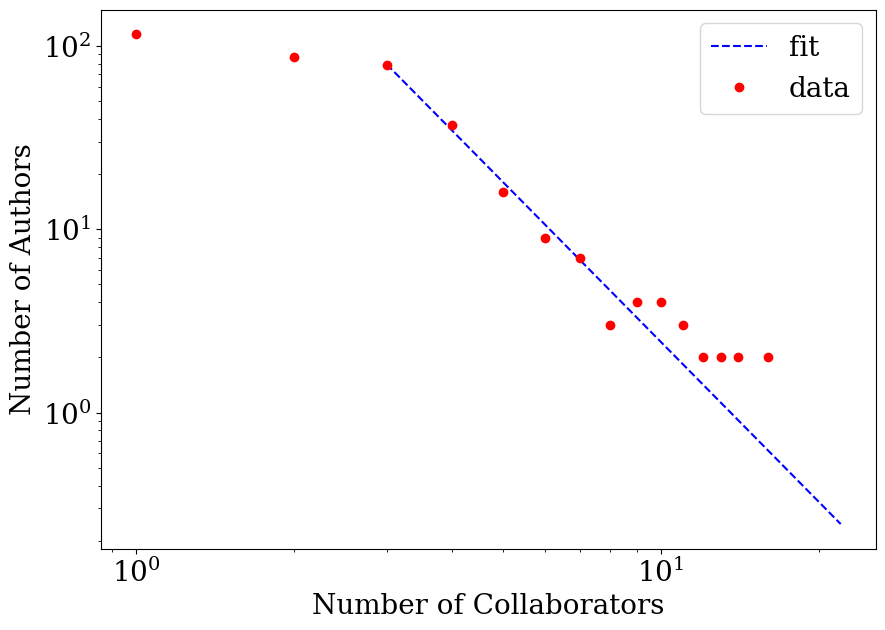

In [103]:
import matplotlib.pyplot as plt, numpy as np, math
from scipy.optimize import curve_fit

plt.figure(figsize=(10,7))

# Define the power-law function
def power_law(x, a, b):
    return a * np.power(x, b)

# Initiate data
x = np.linspace(1,22,22)
y = [list(co_worker_ranking.values()).count(i) for i in range(1,23)]
x_fit = x[2:]
y_fit = y[2:]

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, x_fit, y_fit)

# Plot the fitted power-law curve
y_fit = power_law(x_fit, *popt)
plt.loglog(x_fit, y_fit, '--b', label='fit')

# Plot the data on a log-log scale
plt.loglog(x, y, 'or', label='data')

# Add labels and legend
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Authors')
plt.legend()
#plt.axis((0.9e0,0.3e2,0.75e0,1e3))

plt.savefig('../../Figures/DCFS_collaboration_powerlaw.png',bbox_inches='tight')

In [104]:
popt[1]

-2.8982009996590588

Calculating best minimal value for power law fit
1.6989493725803928


Values less than or equal to 0 in data. Throwing out 0 or negative values


<Axes: >

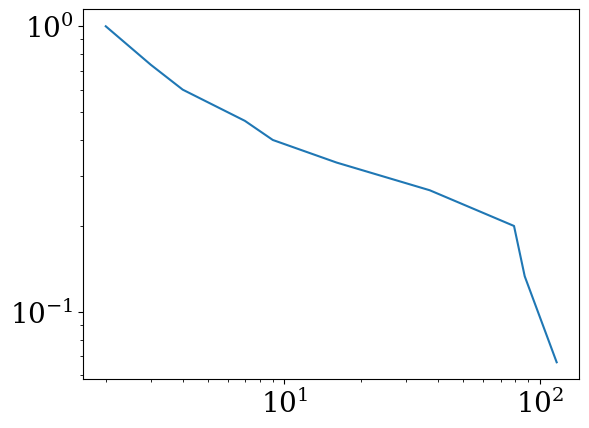

In [105]:
import powerlaw

fit = powerlaw.Fit(y)
print(fit.power_law.alpha)
fit.power_law.sigma
fit.plot_ccdf()

### Collaboration network

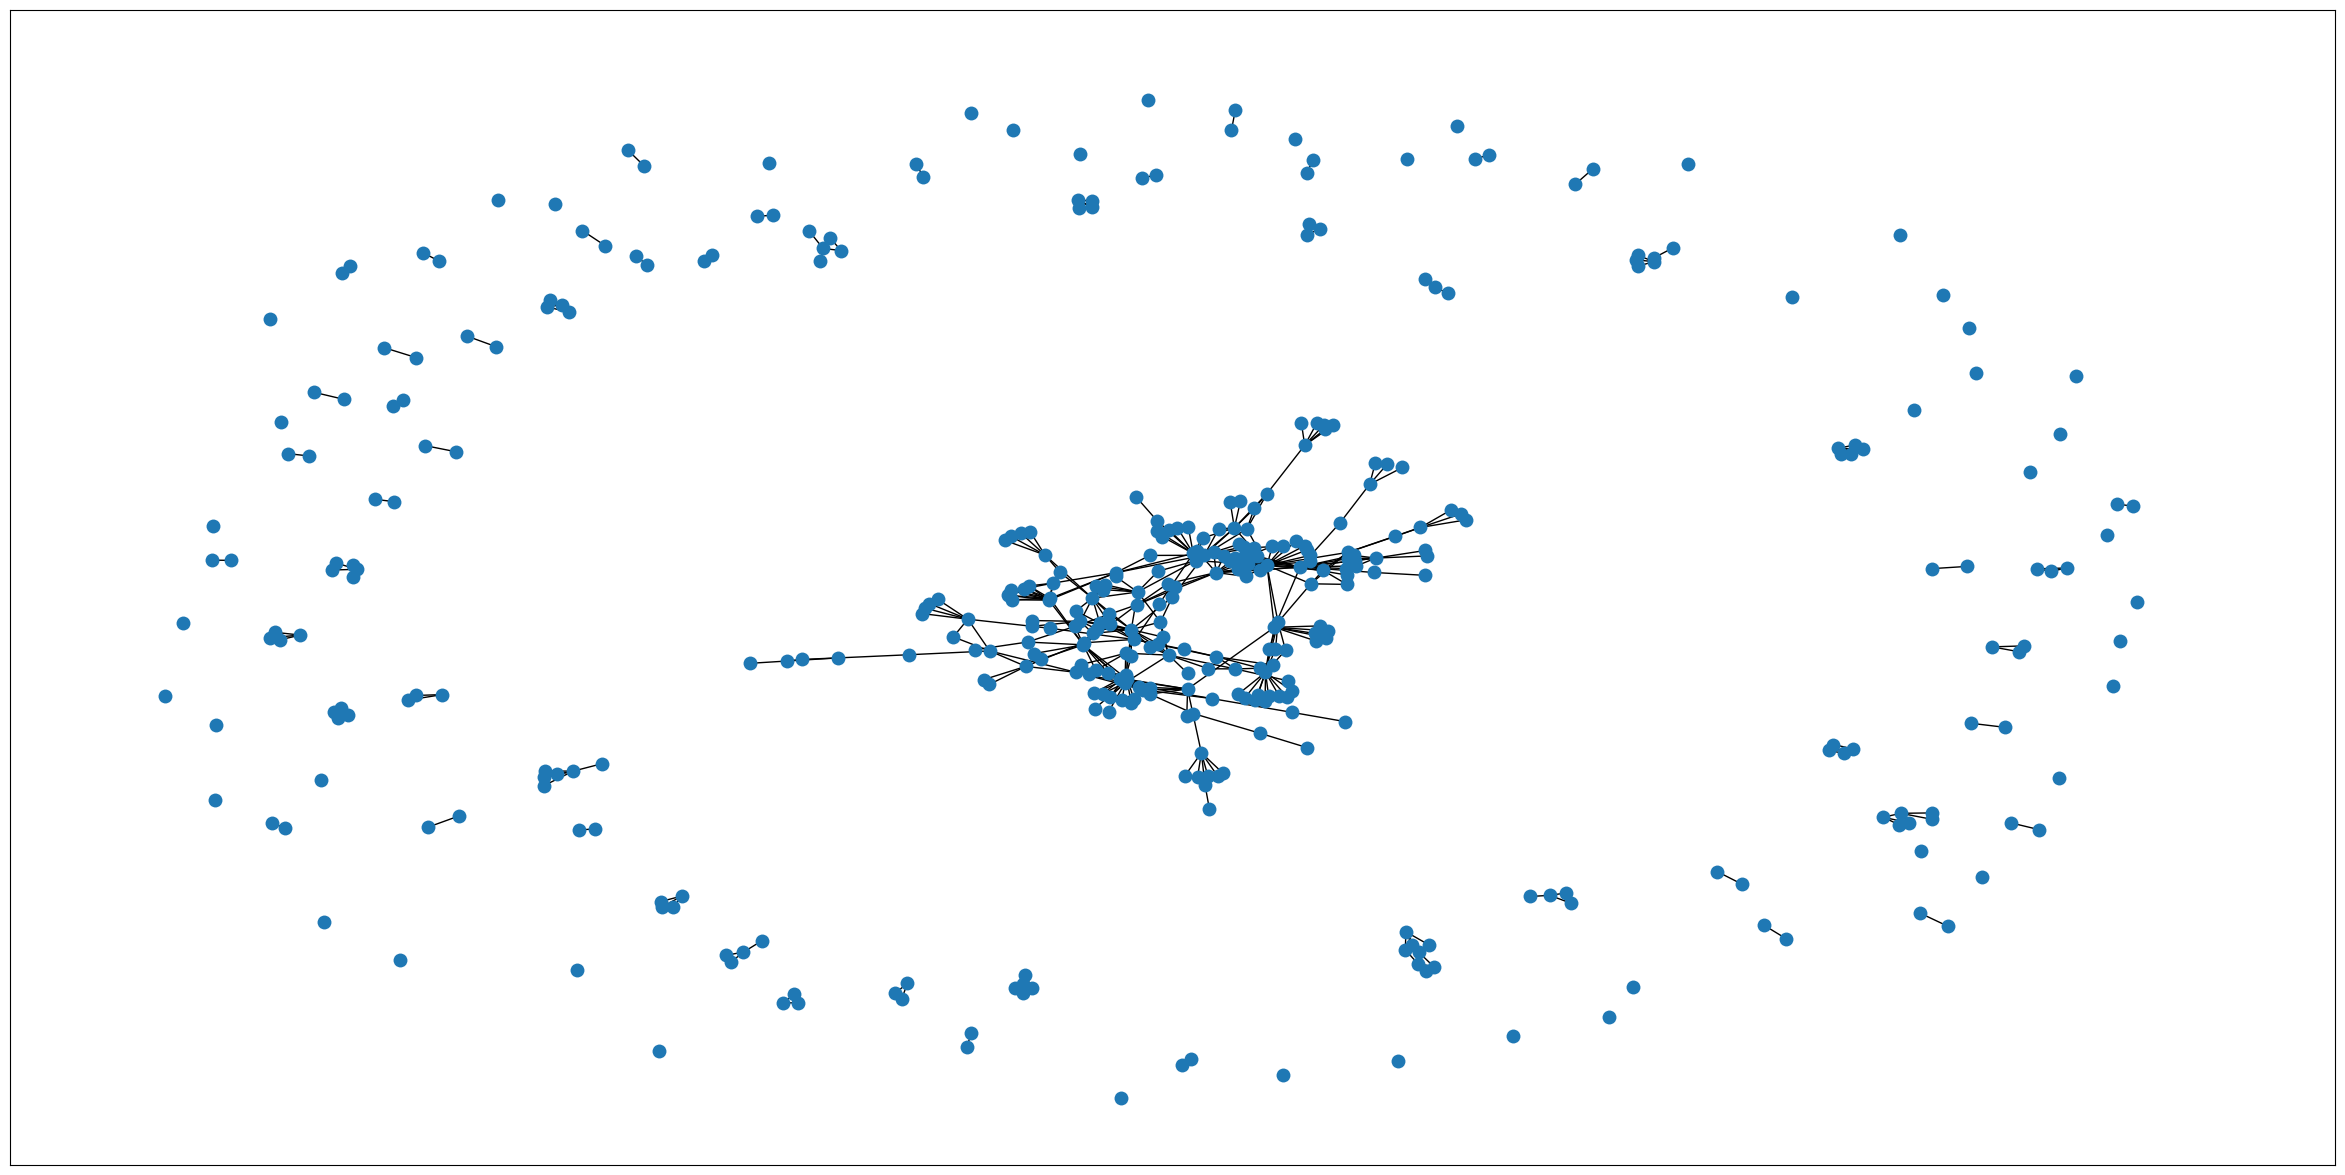

419 564 0.006440488289502232


In [106]:
import networkx as nx, matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(set(dcfs_authors))

for i in range(len(dcfs_authors)):    
    entries = dcfs_co_authors[i].replace('[','').replace(']','').replace('"','').replace("'",'') 
    if entries != '':
        entries = entries.split(', ')
        for entry in entries:
            G.add_edge(dcfs_authors[i],entry)
            #edges.append([authors[i],entry])
            l.append(entry)

# Draw the new graph
plt.figure(figsize=(30,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=False, node_size=100, linewidths=0.0001)
plt.show()
print(G.number_of_nodes(), G.number_of_edges(), nx.density(G))
H = G

In [107]:
# component ranking
print(nx.average_clustering(G))
components = list(nx.connected_components(G))
print(len(components))
components = sorted(components, key=len, reverse=True)[:5]
for i in range(5):
    sub = G.subgraph(components[i])
    print(i)
    print(len(components[i]))
    print(len(components[i])/G.number_of_nodes())
    print(nx.diameter(sub))

0.4751631533851104
104
0
209
0.4988066825775656
13
1
8
0.01909307875894988
2
2
6
0.014319809069212411
2
3
6
0.014319809069212411
2
4
5
0.011933174224343675
1


In [108]:
# Compute the degree of each node
degrees = dict(G.degree())

# Find the node with the highest degree
max_degree_node = max(degrees, key=degrees.get)

# Print the node with the highest degree and its degree
print("Node with the most edges:", max_degree_node)
print("Number of edges:", degrees[max_degree_node])

Node with the most edges: https://dblp.uni-trier.de/pid/02/6009.html
Number of edges: 27


In [109]:
# Calculating the diameter
n = G.number_of_nodes()
m = G.number_of_edges()
d = 2*m/(n*(n-1))
print('The diameter of G is: '+str(d))

The diameter of G is: 0.006440488289502232


/var/folders/68/zr6z7wd56pl2hspyj9v4d57m0000gn/T/ipykernel_30526/3307410384.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv', len(components))


{'https://dblp.uni-trier.de/pid/77/1889.html': array([-0.05266842, -1.        ]), 'https://dblp.uni-trier.de/pid/79/10307.html': array([ 0.36831593, -0.91189505]), 'https://dblp.uni-trier.de/pid/45/476.html': array([-0.07716645,  0.01108959]), 'https://dblp.uni-trier.de/pid/09/906.html': array([ 0.42326782, -0.76289502]), 'https://dblp.uni-trier.de/pid/41/4735.html': array([ 0.06296903, -0.09651354]), 'https://dblp.uni-trier.de/pid/22/5583.html': array([ 0.2662667 , -0.15701995]), 'https://dblp.uni-trier.de/pid/38/7589.html': array([-0.03331655, -0.02111178]), 'https://dblp.uni-trier.de/pid/k/JarkkoKari.html': array([-0.22294065, -0.84423797]), 'https://dblp.uni-trier.de/pid/20/7399.html': array([0.75582479, 0.28856425]), 'https://dblp.uni-trier.de/pid/81/54.html': array([-0.05372138, -0.09676338]), 'https://dblp.uni-trier.de/pid/f/HenningFernau.html': array([0.0371609 , 0.03520583]), 'https://dblp.uni-trier.de/pid/f/ZoltanFulop1.html': array([ 0.85774731, -0.27225854]), 'https://dblp.

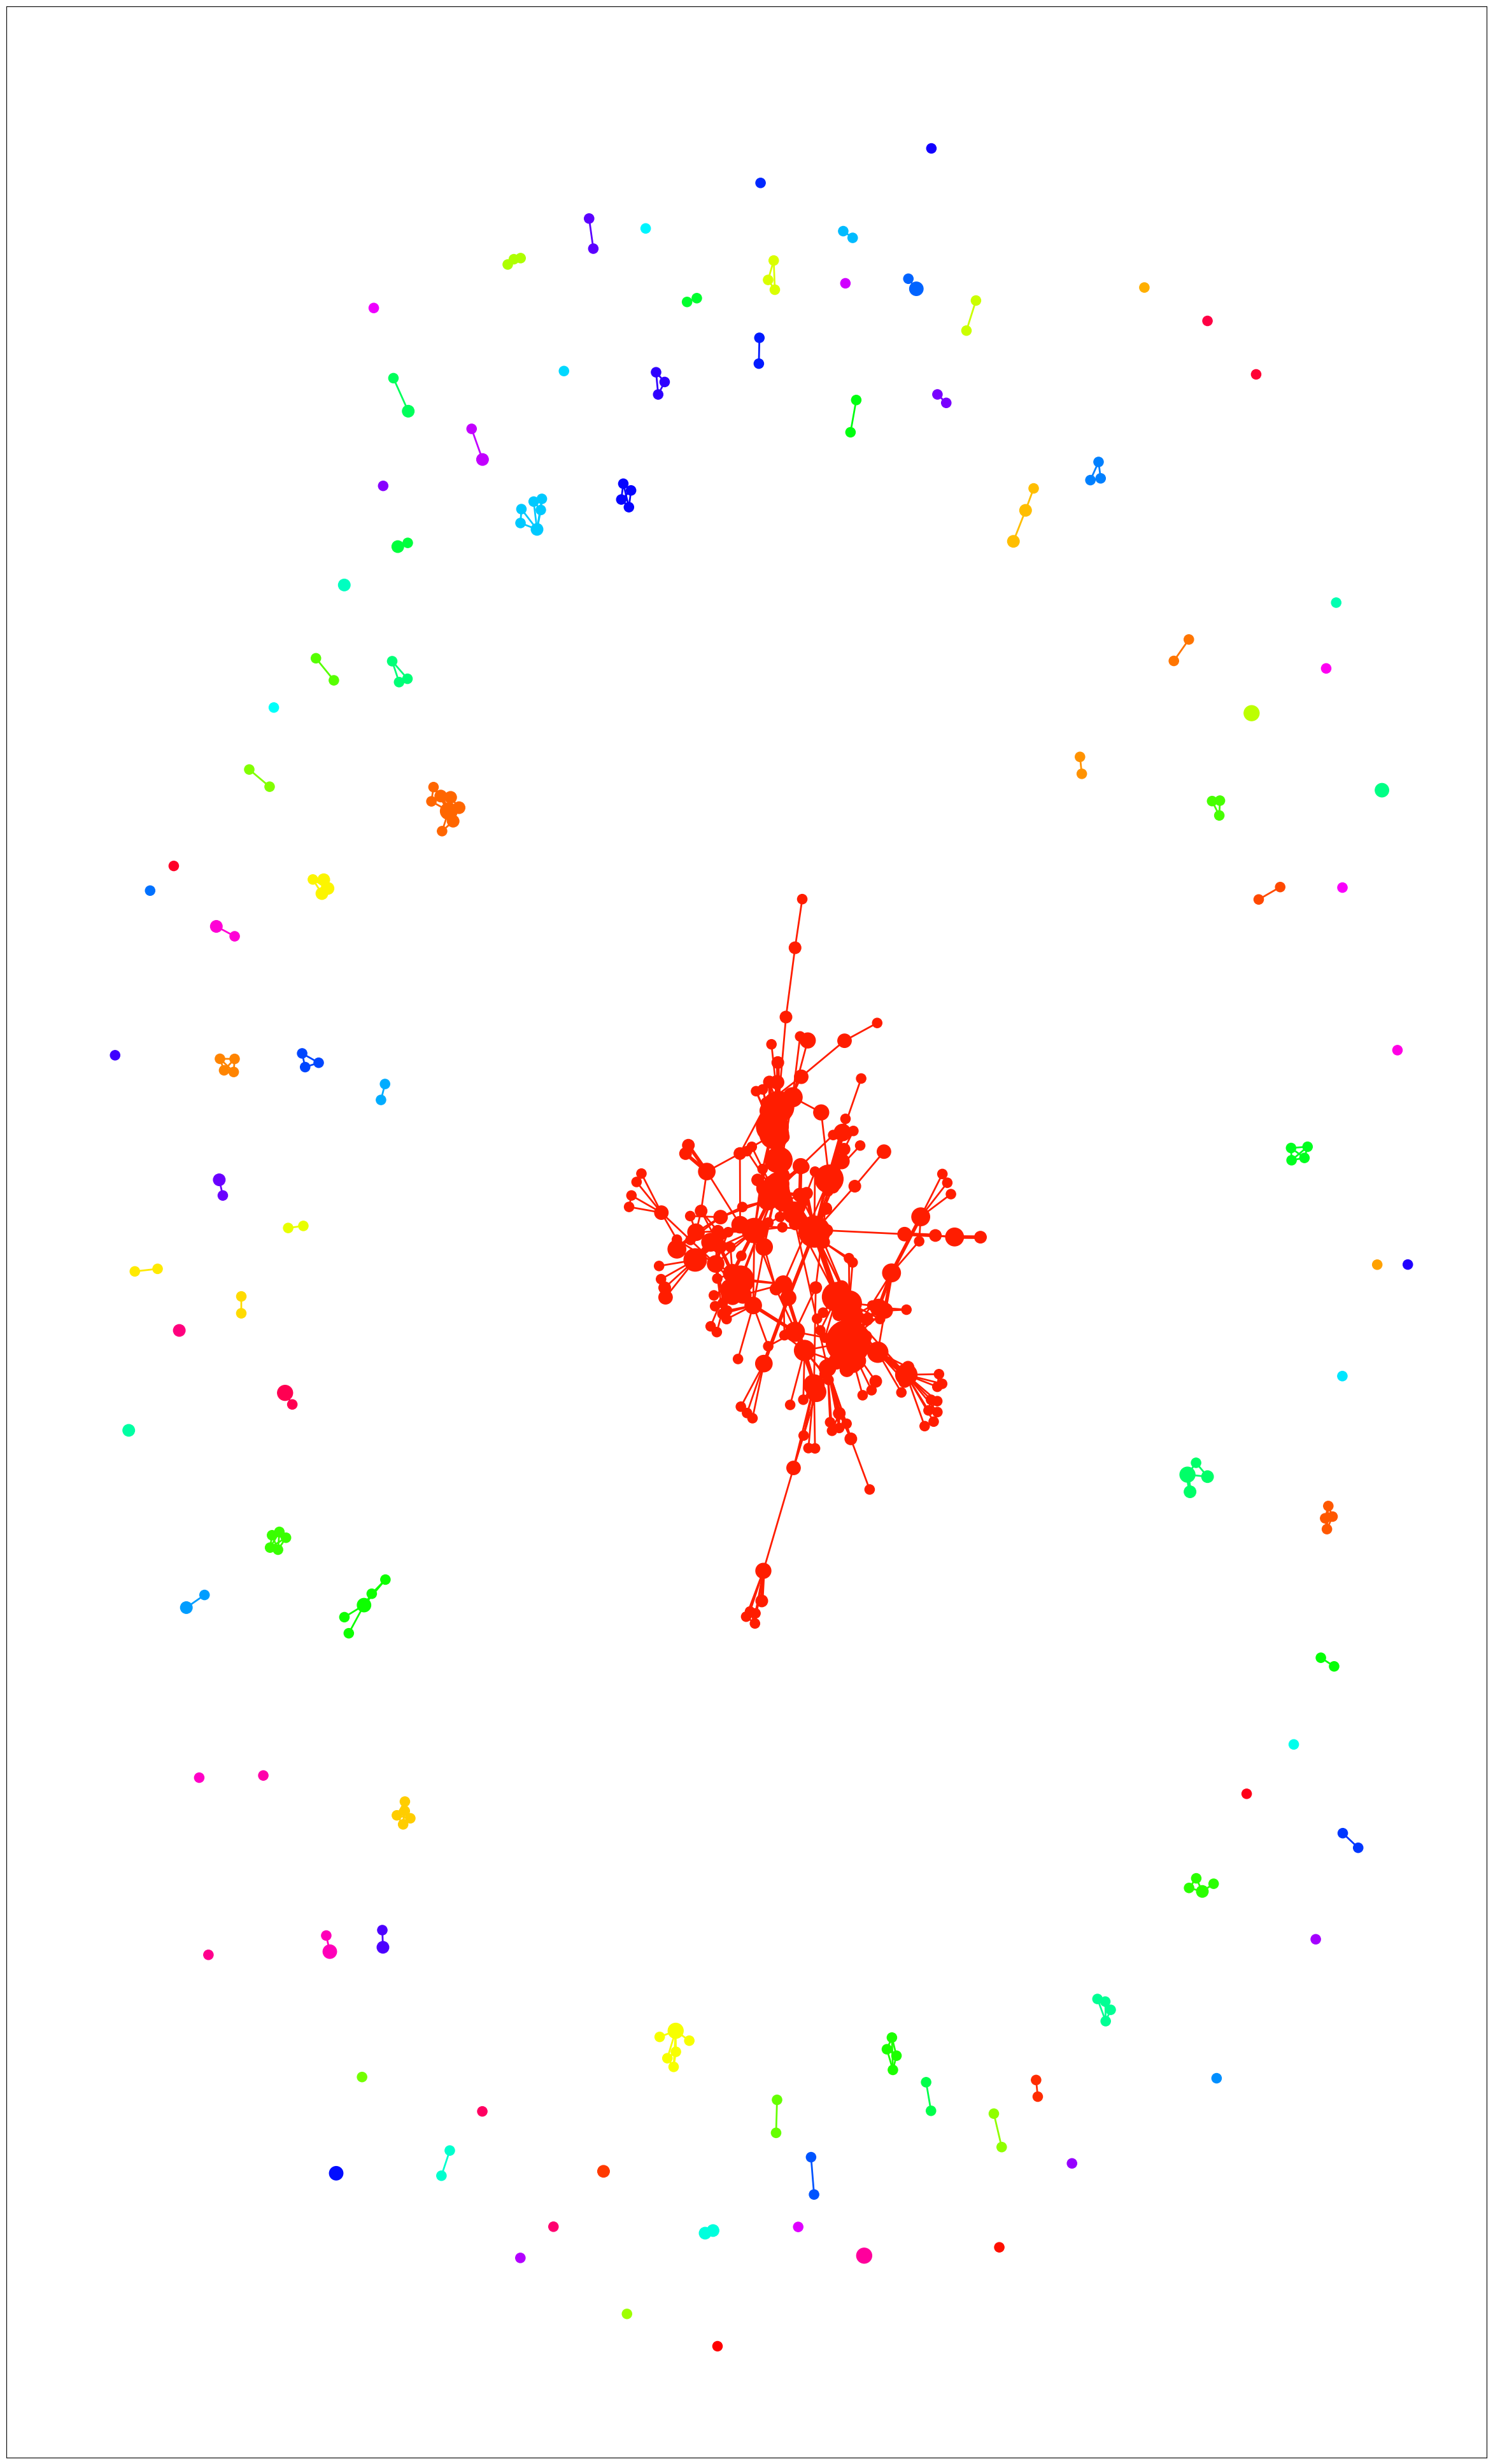

In [110]:
import matplotlib.cm as cm, random

df = data

authors = df['Author'].to_list()

edge_weights = {}
for edge in G.edges():
    weight_a = 0
    weight_b = 0
    entries = df.loc[df['Author']==edge[0]]['Co-Authors'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','').replace("'",'')
        entry = entry.split(', ')
        if edge[1] in entry: weight_a += 1
    entries = df.loc[df['Author']==edge[1]]['Co-Authors'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','')
        entry = entry.split(', ')
        if edge[0] in entry: weight_b += 1
    edge_weights[edge] = 2*max(weight_a, weight_b)

ciaa_author_dict = pd.read_csv('../data/processed/CIAA-authors.csv', sep=';')
dcfs_author_dict = pd.read_csv('../data/processed/DCFS-authors.csv', sep=';')
ciaa_author_dict = {ciaa_author_dict['URL'].to_list()[i]: ciaa_author_dict['Name'].to_list()[i] for i in range(len(ciaa_author_dict['URL'].to_list()))}
dcfs_author_dict = {dcfs_author_dict['URL'].to_list()[i]: dcfs_author_dict['Name'].to_list()[i] for i in range(len(dcfs_author_dict['URL'].to_list()))}
def get_Name(url, venue):
    if venue == 'CIAA': return ciaa_author_dict[url]
    elif venue == 'DCFS': return dcfs_author_dict[url]
    else: return 'ERROR'

plt.figure(figsize=(30,50))

# Find connected components
components_0 = list(nx.connected_components(G))
components = sorted(components_0,key=len,reverse=True)
giant_component = components[0]
five_components = components[0:5]

# Set author names as labels isntead of urls
labels = {node: get_Name(node,'DCFS') for node in G.nodes() if node not in giant_component}
nx.set_node_attributes(G, labels, 'label')

# Set edge weights
nx.set_edge_attributes(G, edge_weights, 'weight')

# Generate a colormap based on the number of components
cmap = cm.get_cmap('hsv', len(components))

# Create a dictionary to store node-color mapping
node_colors = {}

# Assign colors to nodes based on connected components
for i, component in enumerate(components_0):
    color = cmap(i)
    for node in component:
        node_colors[node] = color

# Count occurrences of each node in the list
node_counts = {node: authors.count(node)+1 for node in G.nodes()}

# Compute node sizes based on counts
max_count = max(node_counts.values())
node_sizes = [count / max_count * 2500 for count in node_counts.values()]  # Adjust the scaling factor (500) as per your preference

# Set node sizes as attributes in the graph
node_size_dict = {node: size for node, size in zip(G.nodes(), node_sizes)}
nx.set_node_attributes(G, node_size_dict, 'node_size')

# Create a list to store edge colors
edge_colors = []

# Iterate over the edges and assign colors based on node colors
for edge in G.edges():
    node1, node2 = edge
    color1 = node_colors[node1]
    color2 = node_colors[node2]
    if color1 == color2:
        edge_colors.append(color1)
    else:
        edge_colors.append('black')  # Assign a different color for edges connecting nodes with different colors


# Draw the graph with node colors
pos = nx.spring_layout(G, iterations=40)
nx.draw_networkx(G, pos, node_color=[node_colors[node] for node in G.nodes()], node_size=list(node_sizes), width=[edge_weights[edge] for edge in G.edges()], edge_color=edge_colors, labels=labels, with_labels=False, font_size=6)

# Show the graph
plt.savefig('../../Figures/DCFS-DCFS.png',bbox_inches='tight')
print(pos)

209


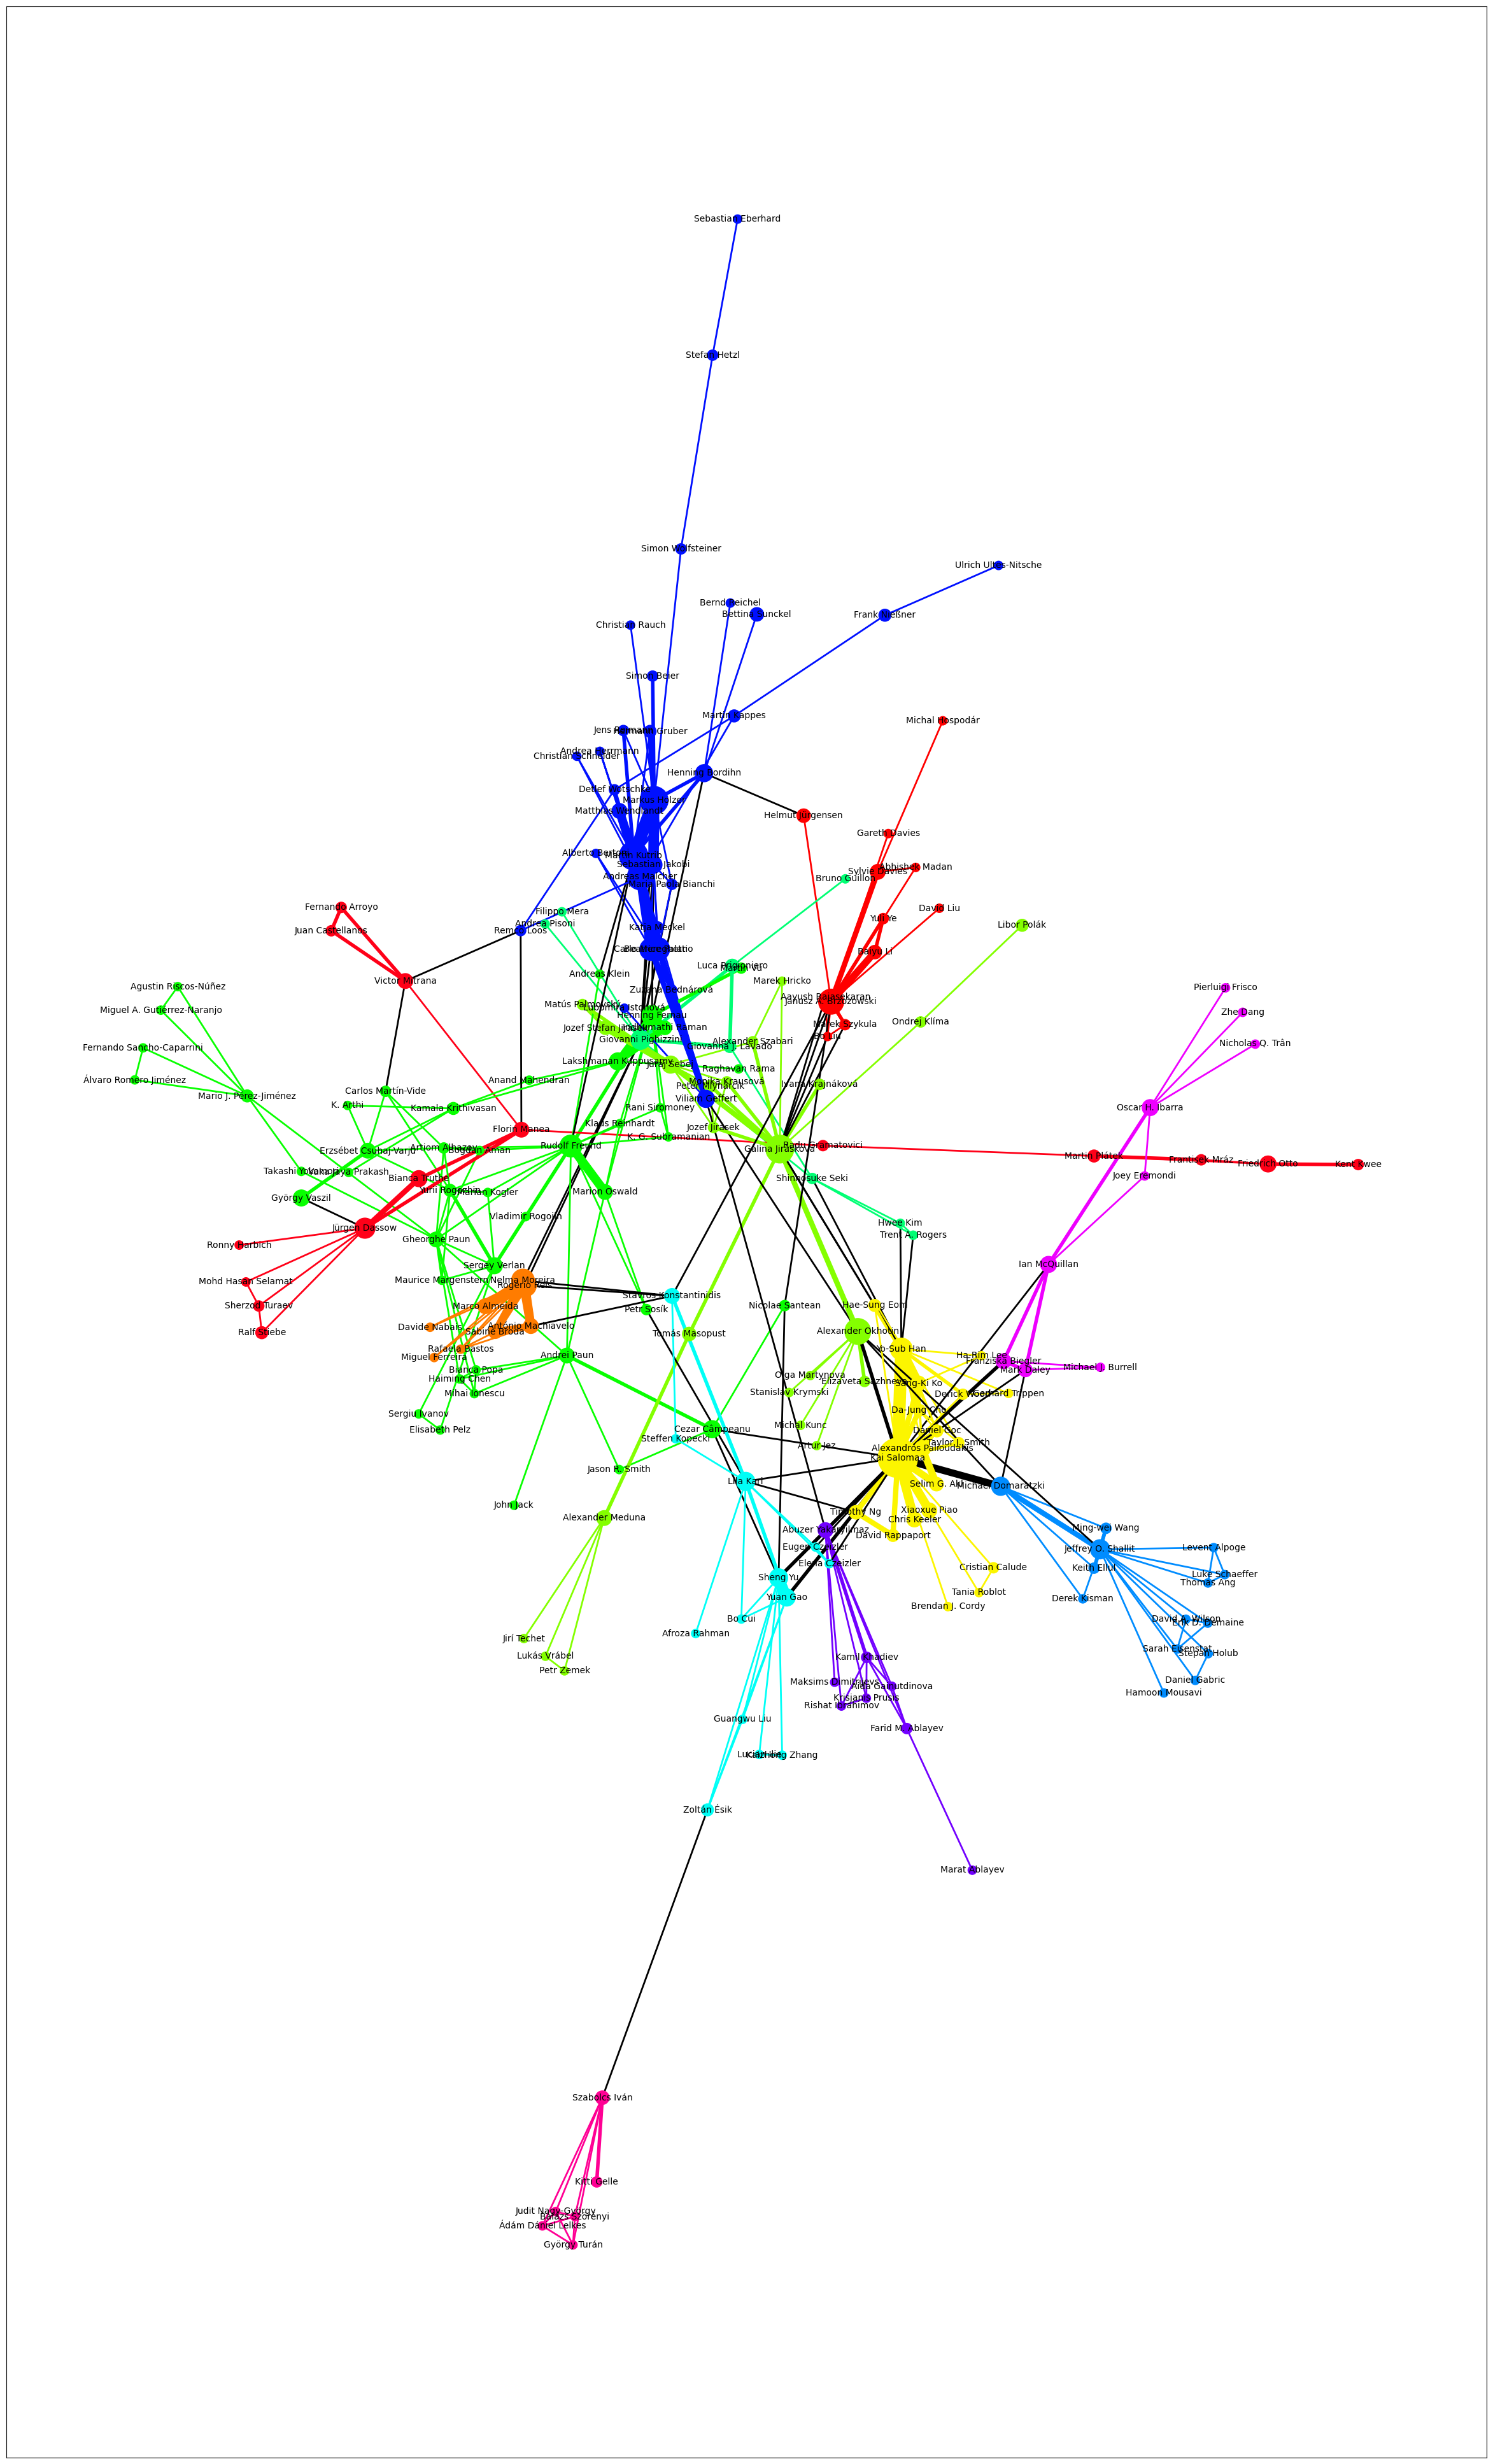

In [111]:
g = G.subgraph(giant_component)

plt.figure(figsize=(30,50))

# Compute edge weight
edge_weights = {}
for edge in g.edges():
    weight_a = 0
    weight_b = 0
    entries = df.loc[df['Author']==edge[0]]['Co-Authors'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','').replace("'",'')
        entry = entry.split(', ')
        if edge[1] in entry: weight_a += 1
    entries = df.loc[df['Author']==edge[1]]['Co-Authors'].to_list()
    for entry in entries:
        entry = entry.replace('[','').replace(']','')
        entry = entry.split(', ')
        if edge[0] in entry: weight_b += 1
    edge_weights[edge] = 2*max(weight_a, weight_b)

# Set author names as labels instead of urls
labels = {node: get_Name(node,'DCFS') for node in g.nodes()}
nx.set_node_attributes(G, labels, 'label')

# Count occurrences of each node in the list
node_counts = {node: authors.count(node)+1 for node in g.nodes()}

# Compute node sizes based on counts
max_count = max(node_counts.values())
node_sizes = [count / max_count * 2000 for count in node_counts.values()]  # Adjust the scaling factor (500) as per your preference

# Set node sizes as attributes in the graph
node_size_dict = {node: size for node, size in zip(g.nodes(), node_sizes)}
nx.set_node_attributes(g, node_size_dict, 'node_size')

import community
# Find the communities
partition = community.best_partition(g)

# Create a color map
cmap = plt.get_cmap('hsv')
colors = []
color_dict = {}
for node in g.nodes():
    res = cmap(partition[node] / max(partition.values()))
    colors.append(res)
    color_dict[node] = res

# Iterate over the edges and assign colors based on node colors
edge_colors = []
for edge in g.edges():
    node1, node2 = edge
    color1 = color_dict[node1]
    color2 = color_dict[node2]
    if color1 == color2:
        edge_colors.append(color1)
    else:
        edge_colors.append('black')  # Assign a different color for edges connecting nodes with different colors

# Draw the graph
pos = {key: value for key,value in pos.items() if key in g.nodes()}
nx.draw_networkx(g, pos, node_color=[color_dict[node] for node in g.nodes()], node_size=list(node_sizes), with_labels=True, labels=labels, width=[edge_weights[edge] for edge in g.edges()], edge_color=edge_colors, font_size=10)
#nx.draw_networkx(g,pos,labels=labels)
# Show the graph
plt.savefig('../../Figures/DCFS-DCFS_giant_component.png',bbox_inches='tight')

print(g.number_of_nodes())

TypeError: 'NoneType' object is not iterable

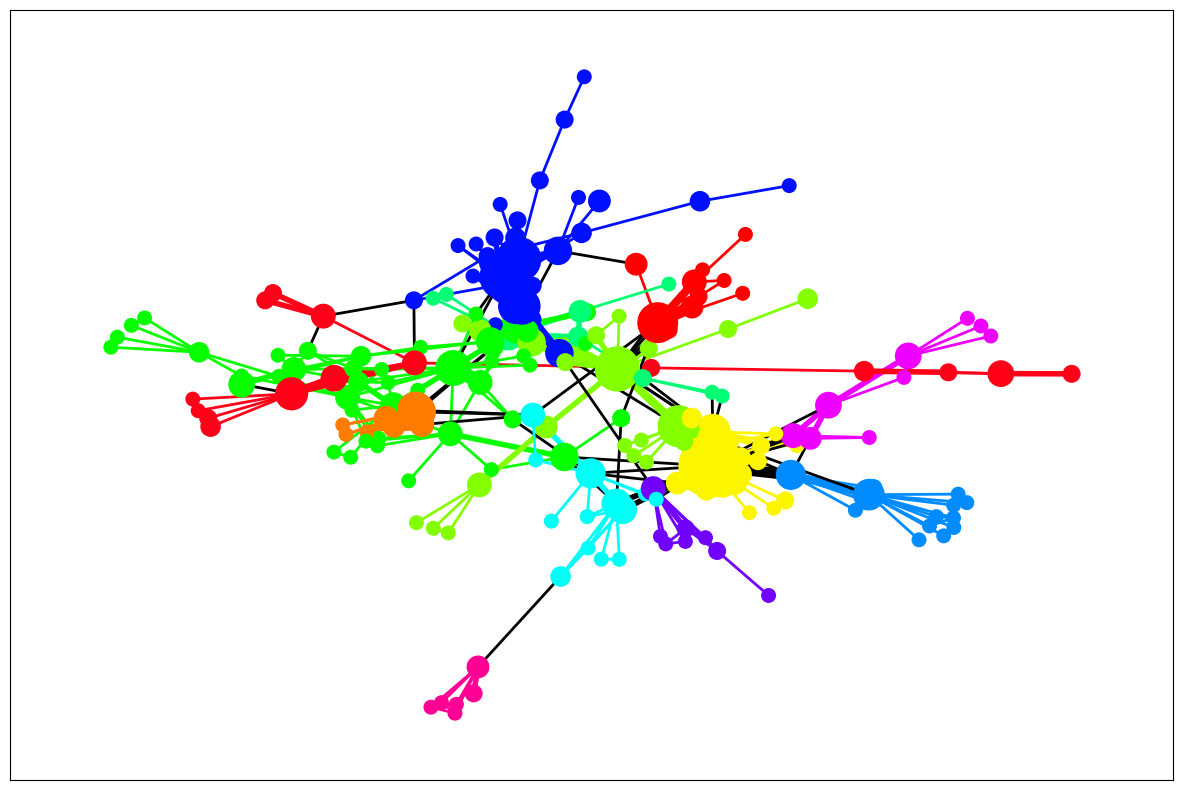

In [112]:
plt.figure(figsize=(15,10))
nx.draw_networkx(nx.draw_networkx(g, pos, node_color=[color_dict[node] for node in g.nodes()], node_size=list(node_sizes), with_labels=False, labels=labels, width=[edge_weights[edge] for edge in g.edges()], edge_color=edge_colors, font_size=10))
plt.savefig('../../Figures/DCFS-DCFS_giant_component_small.png',bbox_inches='tight')

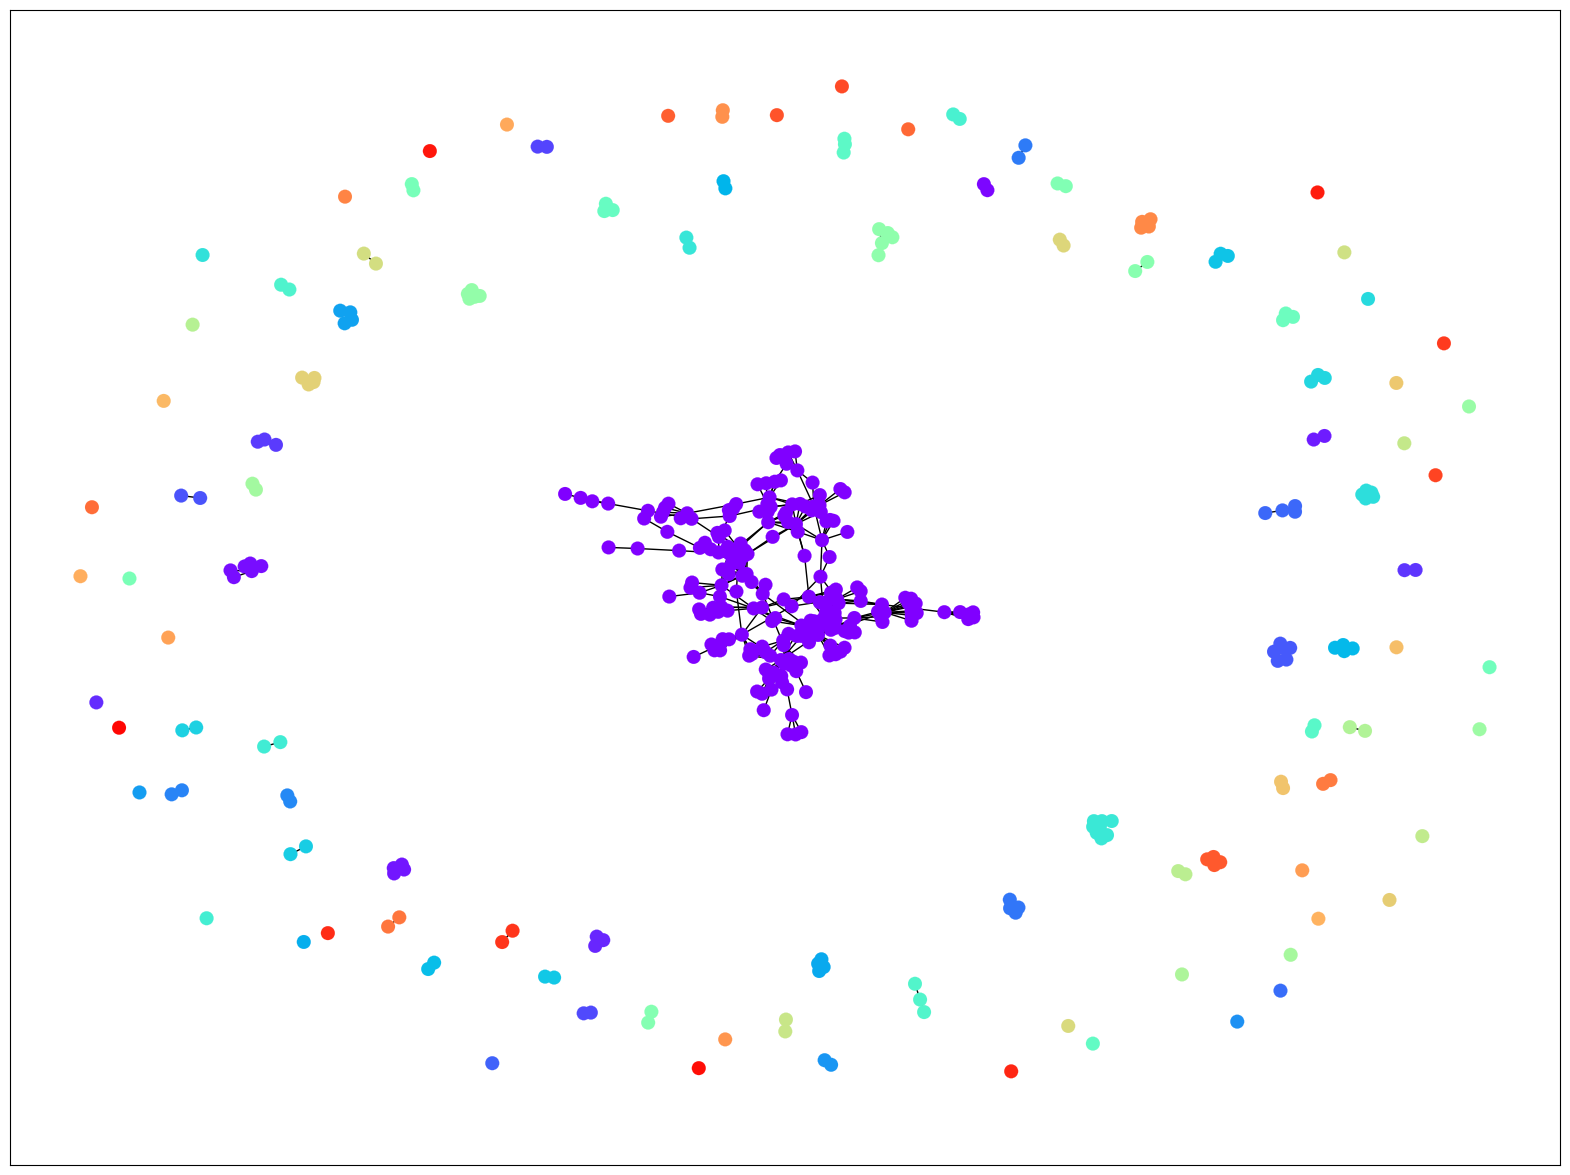

419


In [ ]:
# Coloring components
components = list(nx.connected_components(G))

# Create a color map
num_components = len(components)
colors = plt.cm.rainbow([i/num_components for i in range(num_components)])

# Assign a color to each node based on its component
color_map = {}
for i, component in enumerate(components):
    for node in component:
        color_map[node] = colors[i]

# Draw the graph
plt.figure(figsize=(20,15))
nx.draw_networkx(G, node_color=[color_map[node] for node in G.nodes()], node_size=100, linewidths=0.1, with_labels=False)
plt.show()
dcfs_nodes_all = list(G.nodes())
print(len(dcfs_nodes_all))

In [ ]:
# Clustering coefficient
print('The clustering coefficient of G is: '+str(nx.average_clustering(G)))

The clustering coefficient of G is: 0.4751631533851103


In [ ]:
# Calculate betweenness centrality

def get_name(url):
    df = pd.read_csv('../data/cleaned/DCFS-DCFS.csv',sep=';')
    name = df.loc[df['Author-URL']==url]
    name = name['Author'].to_list()
    name = repr(name[0]).replace('[','').replace(']','').replace('"','').replace("'",'')
    return name

betweenness_centrality = nx.betweenness_centrality(G)

betweenness_sorted = dict(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))
betweenness_sorted = {get_name(key): value for key, value in betweenness_sorted.items()}

top10_betwenness = list(betweenness_sorted.items())[:10]

from tabulate import tabulate

headers = ['betweenness']
table1 = tabulate(top10_betwenness, headers, tablefmt='latex')
print(table1)

\begin{tabular}{lr}
\hline
                      &   betweenness \\
\hline
 Kai Salomaa          &     0.0767163 \\
 Alexander Okhotin    &     0.0681857 \\
 Viliam Geffert       &     0.0574196 \\
 Galina Jirásková     &     0.0482918 \\
 Andreas Malcher      &     0.04223   \\
 Rudolf Freund        &     0.0416287 \\
 Janusz A. Brzozowski &     0.0307555 \\
 Martin Kutrib        &     0.0297037 \\
 Giovanni Pighizzini  &     0.0289686 \\
 Andrei Paun          &     0.0280877 \\
\hline
\end{tabular}


The largest component has 213 nodes and 411 edges.


<Figure size 6000x3000 with 0 Axes>

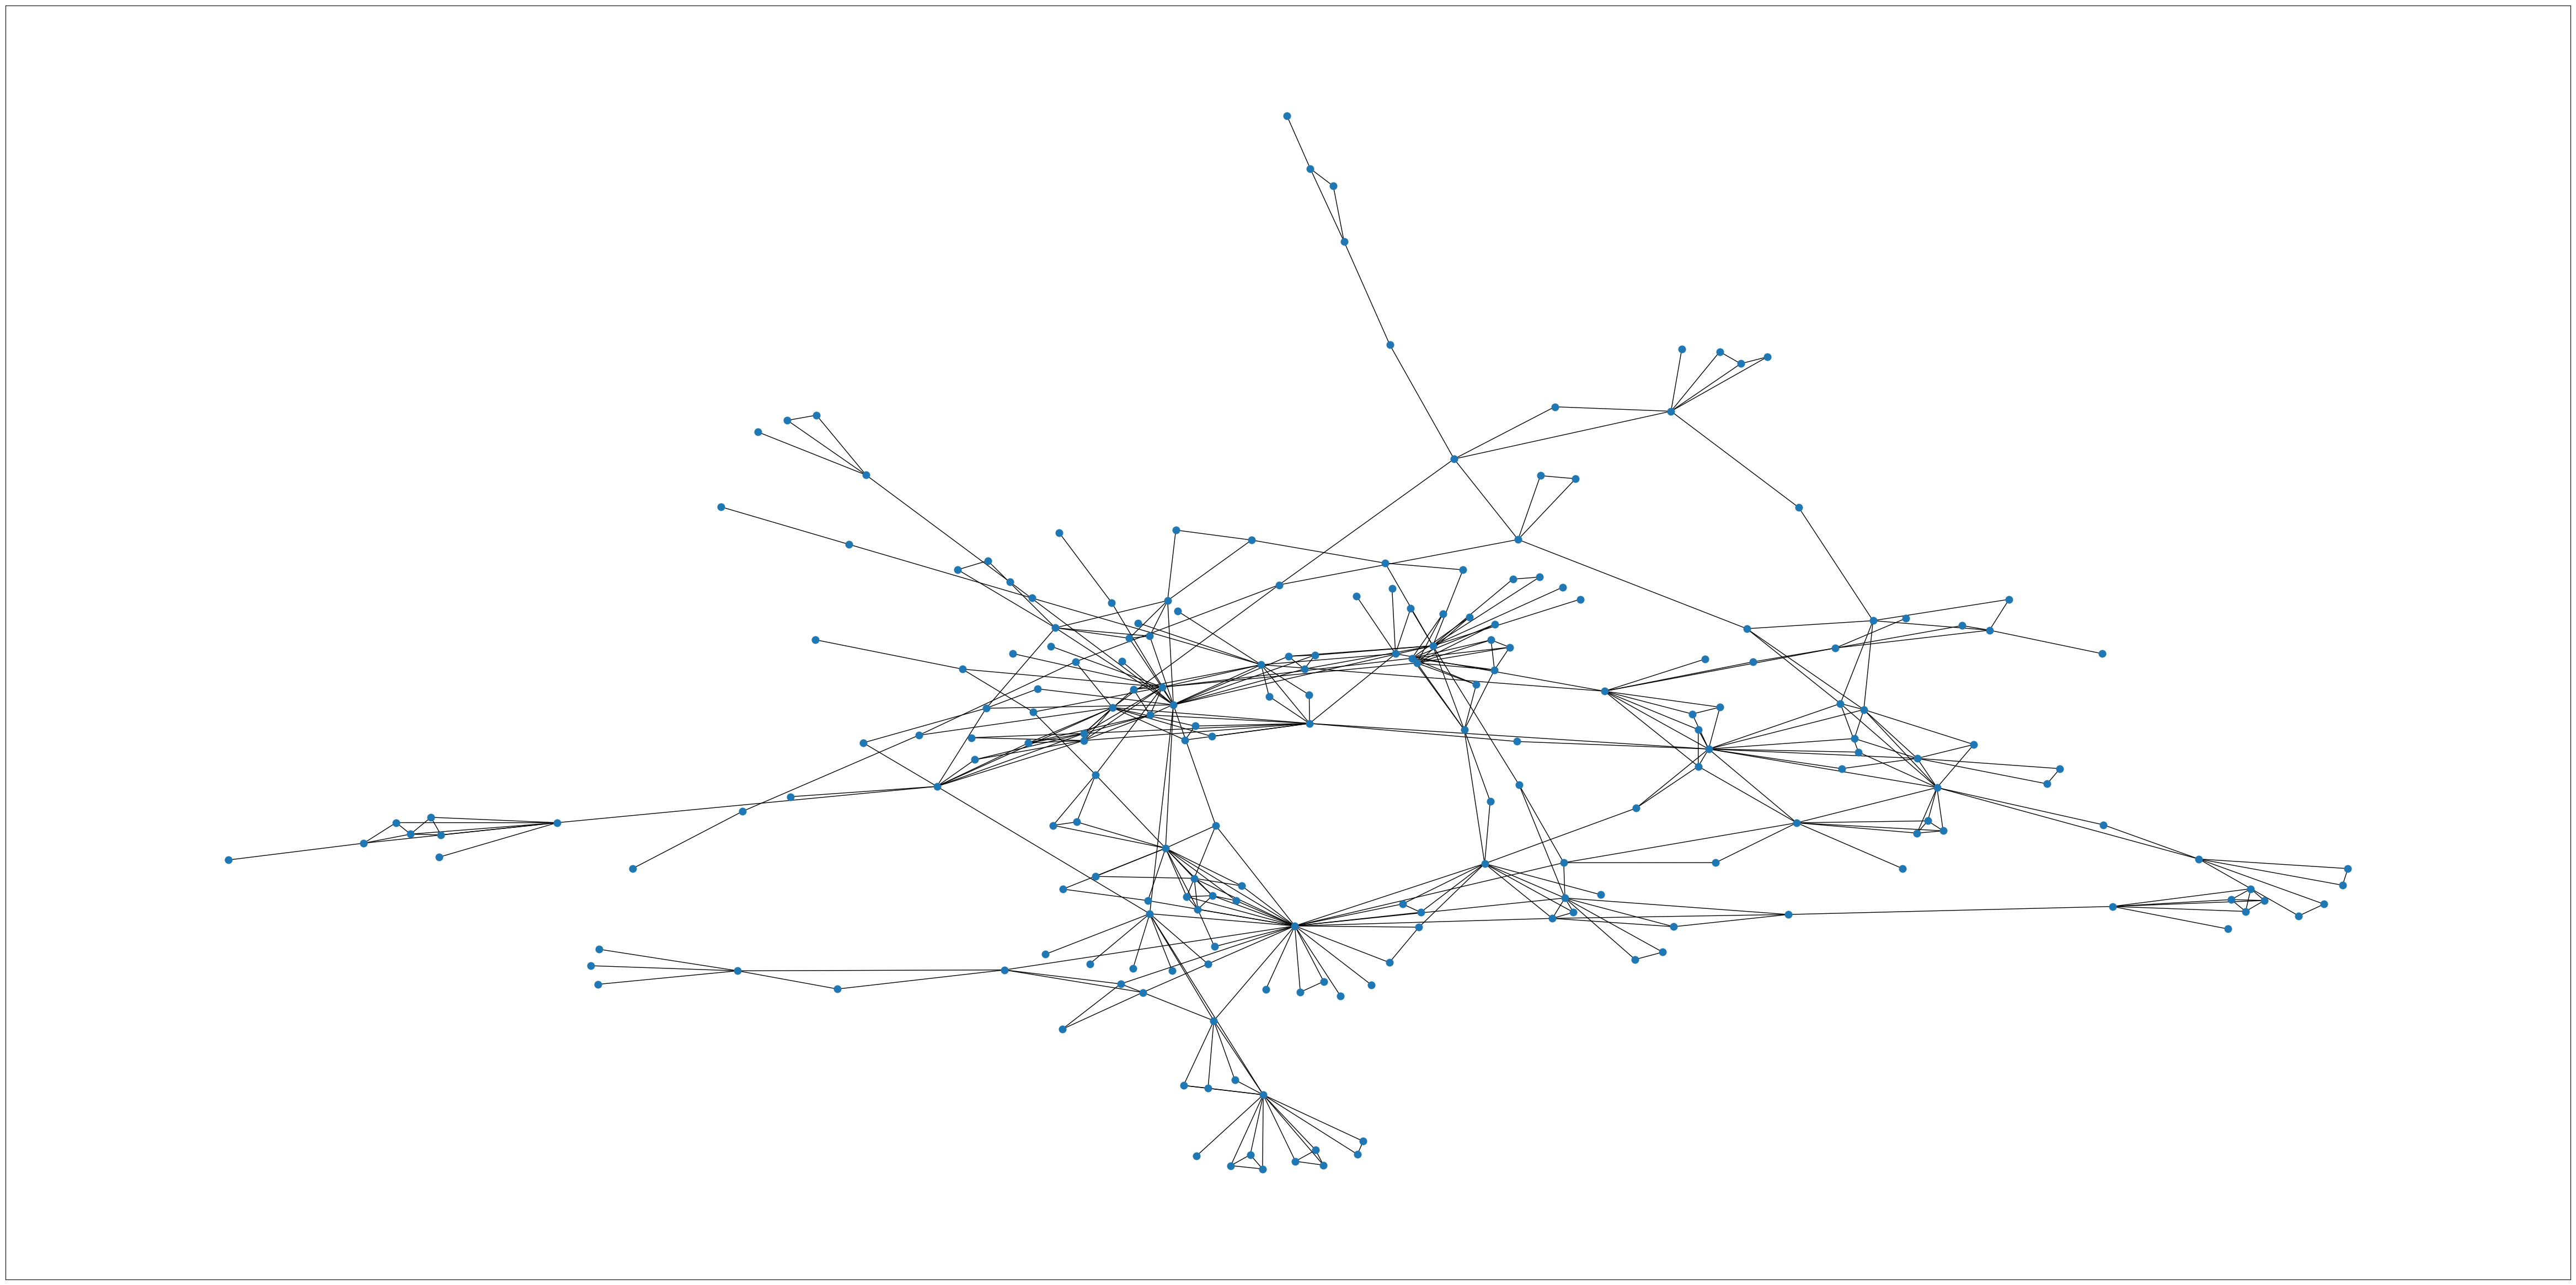

In [ ]:
# Drawing the largest component only
plt.figure(figsize=(60,30))
largest_component = max(components, key=len)
subgraph = G.subgraph(largest_component)
plt.figure(figsize=(60,30))
nx.draw_networkx(subgraph, node_size=100, linewidths=0.1, with_labels=False)
print('The largest component has '+str(subgraph.number_of_nodes())+' nodes and '+str(subgraph.number_of_edges())+' edges.')
plt.show()

The largest community is labeled as 5 and contains 38 nodes.


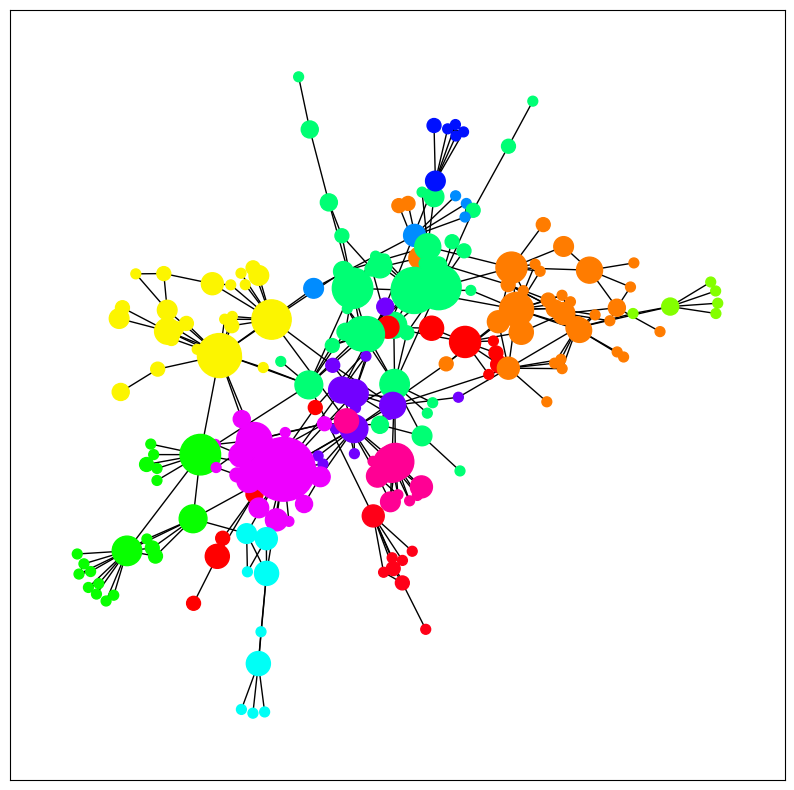

In [ ]:
# Drawing the largest component with its communities and nodes sizes

import community
# Find the communities
partition = community.best_partition(subgraph)

# Create a color map
cmap = plt.get_cmap('hsv')
colors = [cmap(partition[node] / max(partition.values())) for node in subgraph.nodes()]

# Count the number of nodes in each community
community_sizes = {}
for node, community_label in partition.items():
    if community_label not in community_sizes:
        community_sizes[community_label] = 0
    community_sizes[community_label] += 1

# Find the largest community
largest_community_label = max(community_sizes, key=community_sizes.get)
largest_community_size = community_sizes[largest_community_label]

print("The largest community is labeled as", largest_community_label, "and contains", largest_community_size, "nodes.")

G = subgraph
authors = df['Author-URL'].to_list()
nodes = list(G.nodes())
weight = {node: authors.count(node) for node in nodes}
nx.set_node_attributes(G, weight, 'weight')
node_sizes = [50 * G.nodes[node]['weight'] for node in G.nodes()]

edges= list(G.edges())
edge_sizes = {edge: edges.count(edge) for edge in edges}

# Draw the graph
plt.figure(figsize=(10,10))
nx.draw_networkx(G, node_color=colors, node_size=node_sizes, linewidths=1, with_labels=False)
plt.show()

In [ ]:
G.number_of_edges()

411

In [ ]:
edges = list(G.edges())
edge_weights = {}
for edge in edges:
    if edge in collaboration_weight_urls:
        edge_weights[edge] = collaboration_weight_urls[edge]**2
    else:
        edge_weights[(edge[1],edge[0])] = collaboration_weight_urls[(edge[1],edge[0])]
print(max(edge_weights.values()))


196


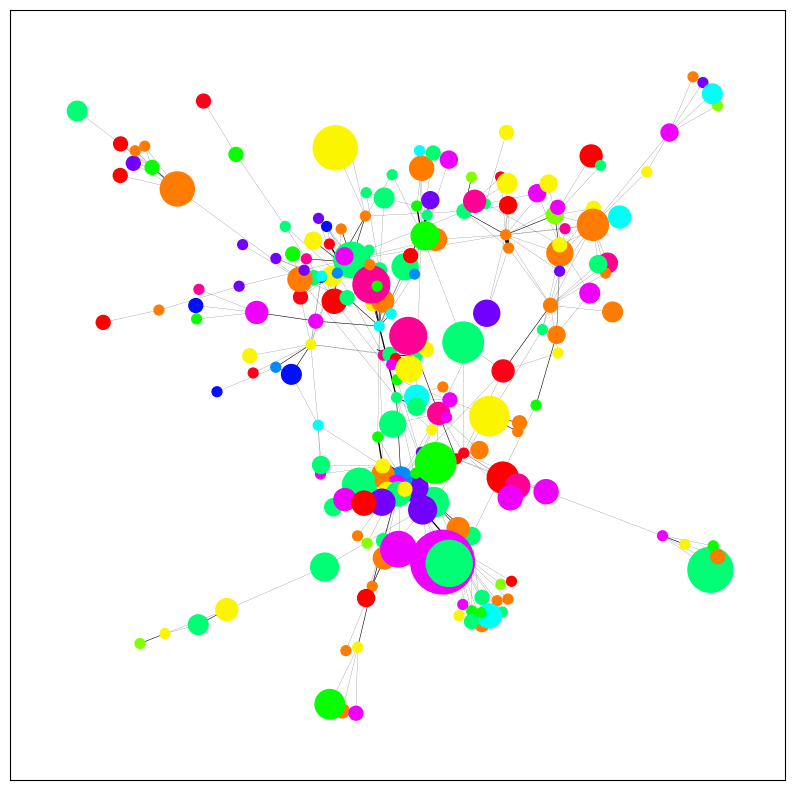

In [ ]:
Z = nx.Graph()

for edge, weight in edge_weights.items():
    Z.add_edge(edge[0], edge[1], weight=weight)


edge_widths = [weight for _, _, weight in Z.edges.data('weight')]
edge_widths_normalized = [width / max(edge_widths) * 20 for width in edge_widths]

plt.figure(figsize=(10,10))

pos = nx.spring_layout(Z)
labels = nx.get_edge_attributes(Z, 'weight')
nx.draw_networkx(Z, pos, node_size=node_sizes, width=edge_widths_normalized, node_color=colors, with_labels=False)
#nx.draw_networkx_edge_labels(Z, pos, edge_labels=labels)

plt.show()

# Draw the graph
# plt.figure(figsize=(10,10))
# nx.draw_kamada_kawai(G, node_color=colors, node_size=node_sizes, linewidths=1)
# plt.show()

In [ ]:
Z.number_of_edges()

411

In [ ]:
import json

# Load the dictionary from the file
with open('../data/raw/CIAA-communities.json', 'r') as f:
    ciaa_communities = json.load(f)
with open('../data/raw/CIAA-nodes.json','r') as f:
    ciaa_nodes = json.load(f)
with open('../data/raw/CIAA-nodes_all.json','r') as f:
    ciaa_nodes_all= json.load(f)
with open('../data/raw/CIAA-largest_community.json','r') as f:
    ciaa_community= json.load(f)

# ciaa_communities = ciaa_communities[0]

dcfs_nodes = list(subgraph.nodes())

In [ ]:
#Comparing the nodes of DCFS and CIAA graphs
intersect_all = []
outside_all = []
for node in dcfs_nodes_all:
    if node in ciaa_nodes_all:
        intersect_all.append(node)
    else:
        outside_all.append(node)
print(len(intersect_all))
print(len(outside_all))

# Comparing the nodes of the largest components
intersect = []
outside = []
for node in dcfs_nodes:
    if node in ciaa_nodes:
        intersect.append(node)
    else:
        outside.append(node)
print(len(intersect))
print(len(outside))


139
295
61
152


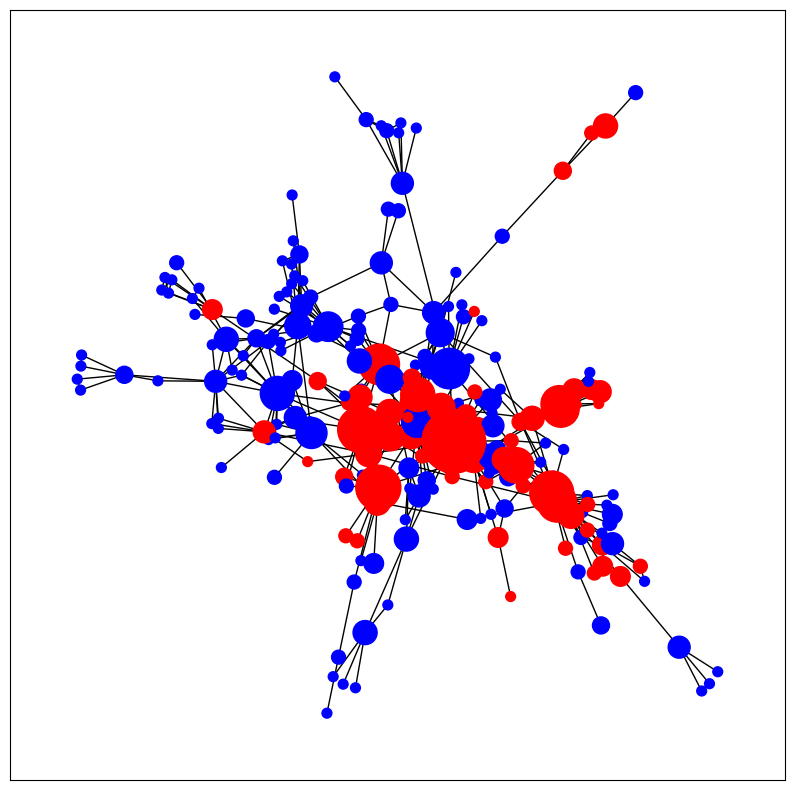

In [ ]:
# Only color the nodes which are in both networks
colors = ['red' if node in intersect else 'blue' for node in G.nodes()]
plt.figure(figsize=(10,10))
subgraph = G.subgraph(intersect)
nx.draw_networkx(G, node_color=colors, node_size=node_sizes, linewidths=1, with_labels=False)
#nx.draw(subgraph)
plt.show()

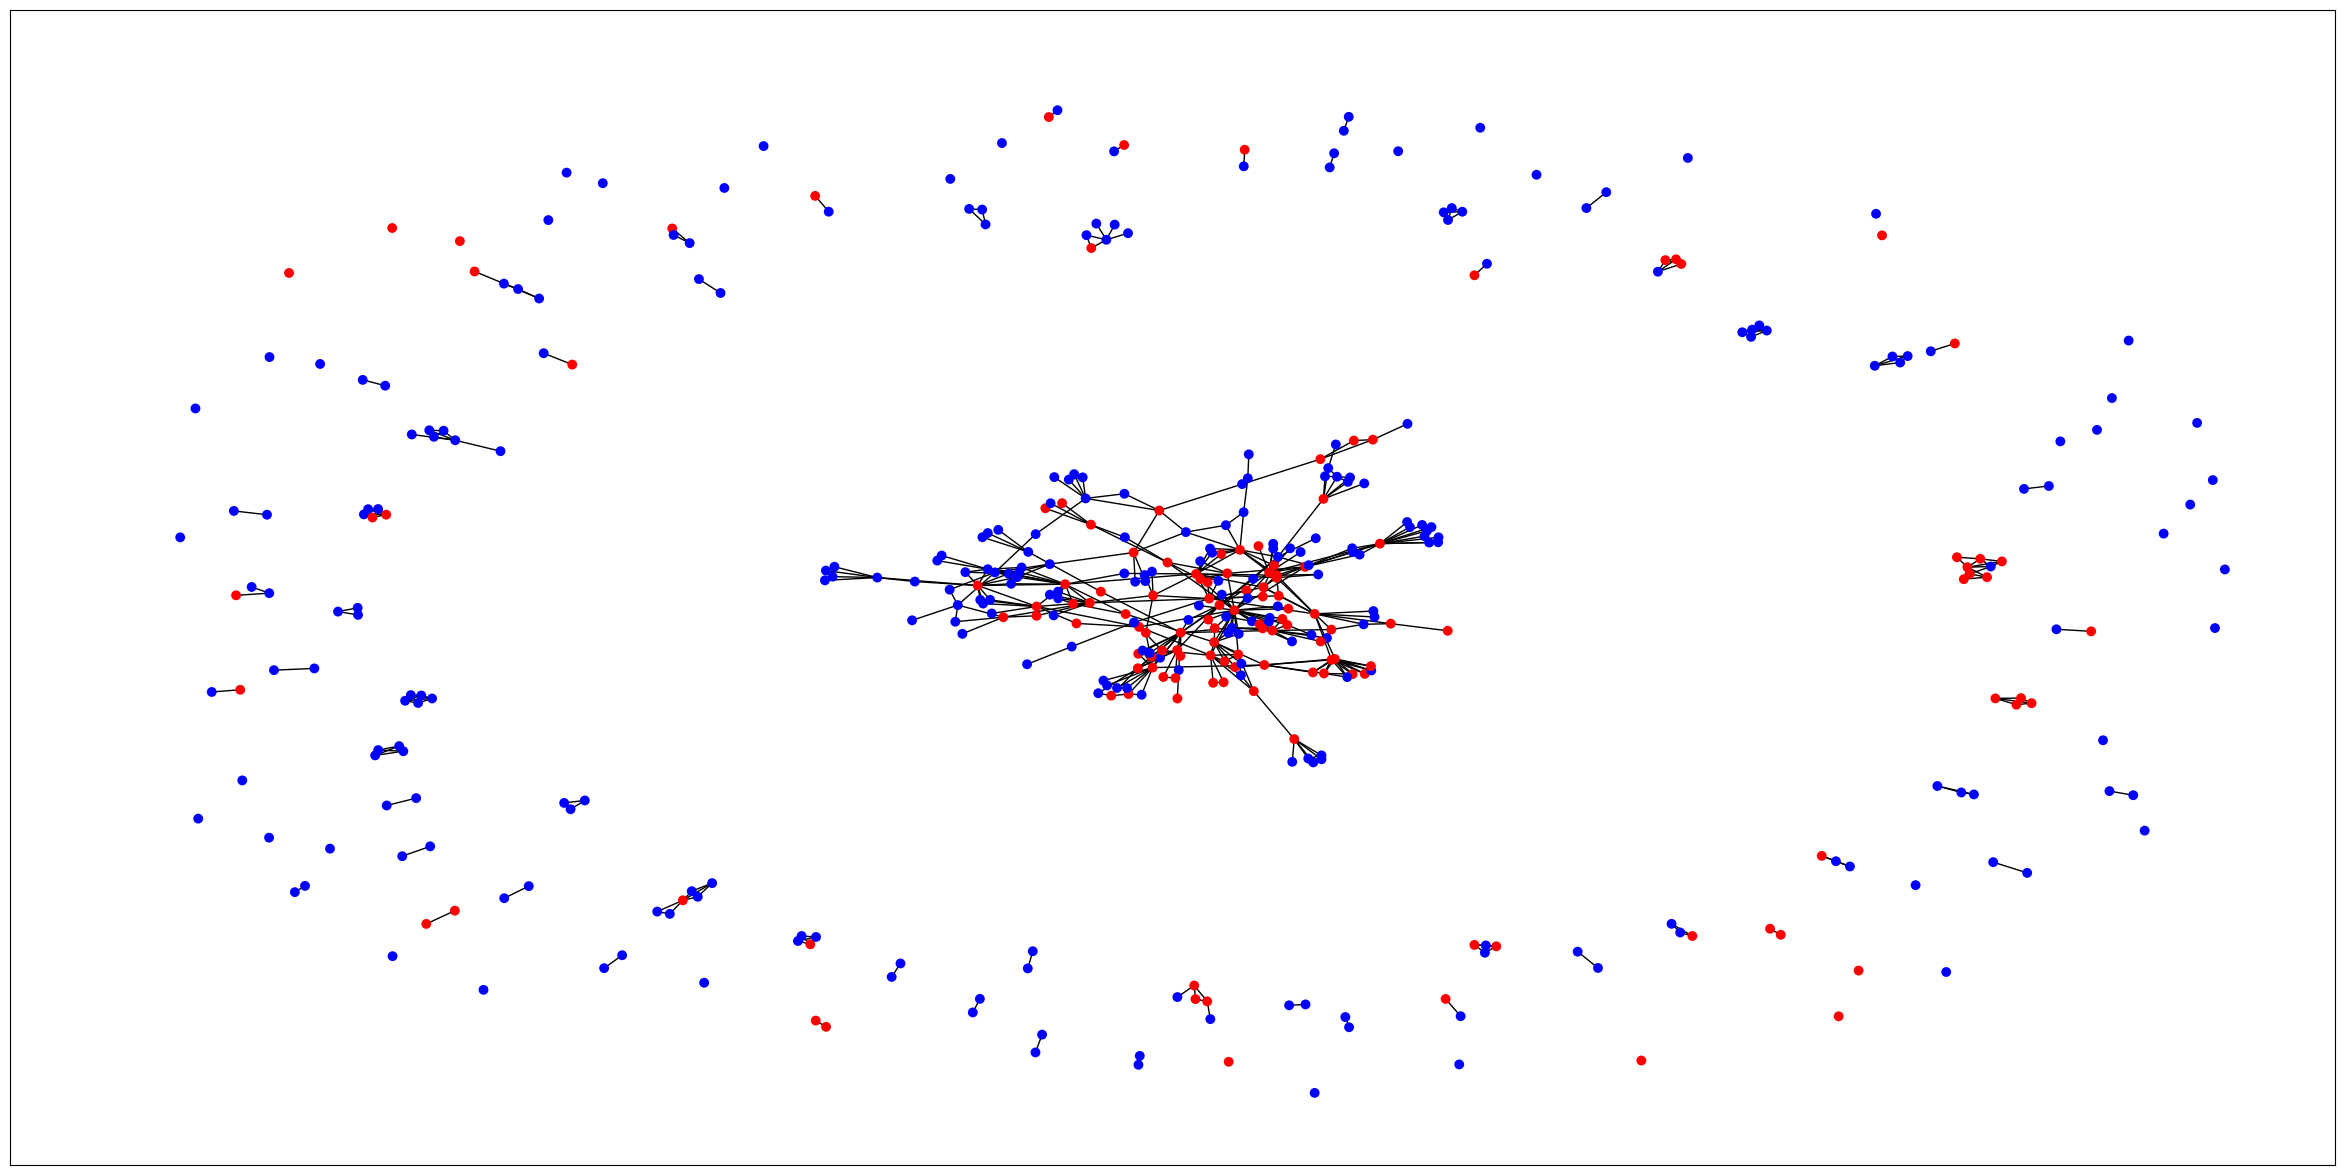

In [ ]:
# Only color the nodes which are in both networks
colors = ['red' if node in intersect_all else 'blue' for node in H.nodes()]
plt.figure(figsize=(30,15))
nx.draw_networkx(H, node_color=colors, node_size=50, linewidths=0.01, with_labels=False)
plt.show()

#### Comparing communities

In [ ]:
# Comparing the communities of the largest components
dcfs_communities = []
for i in range(1,max(partition.values())+1):
    this_community = [key for key in partition.keys() if partition[key] == i]
    dcfs_communities.append(this_community)

print('DCFS community number: '+str(len(dcfs_communities)))
print('CIAA community number: '+str(len(ciaa_communities)))

import decimal

def round_to_sigfigs(number, sigfigs):
    if number == 0:
        return 0
    exponent = decimal.Decimal(str(number)).adjusted()
    scale = 10 ** (sigfigs - exponent - 1)
    rounded_number = round(decimal.Decimal(number) * scale) / scale
    return rounded_number

matrix = []
for i in range(len(dcfs_communities)):
    matrix_entry = []
    for j in range(len(ciaa_communities)):
        res = 0
        for d in dcfs_communities[i]:
            if d in ciaa_communities[j]:
                res += 1
        #res = res/(len(dcfs_communities[i])+len(ciaa_communities[j]))
        res = res/(len(set(dcfs_communities[i]) | set(ciaa_communities[j])))
        matrix_entry.append(round_to_sigfigs(res,3))
    matrix.append(matrix_entry)
matrix
        


DCFS community number: 12
CIAA community number: 10


[[0, 0, 0, 0.0192, 0, 0, 0, 0, 0.0189, 0],
 [0.321, 0, 0, 0.05, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.0244, 0, 0],
 [0, 0.39, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0.0625, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0.037, 0, 0],
 [0, 0, 0, 0.103, 0, 0, 0, 0.0278, 0.138, 0],
 [0, 0, 0, 0, 0, 0.135, 0, 0, 0.139, 0],
 [0.0476, 0, 0.318, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
# Convert list to latex table
def list_to_latex_table(data):
    rows = []
    for row in data:
        row_str = ' & '.join(str(cell) for cell in row)
        rows.append(row_str)
    table = '\\\\ \\hline \n'.join(rows)
    latex_code = '\\begin{tabular}{ ' + 'c' * len(data[0]) + ' }\n'
    latex_code += table + '\n'
    latex_code += '\\end{tabular}'
    return latex_code

latex_table = list_to_latex_table(matrix)
print(latex_table)

\begin{tabular}{ cccccccccc }
0 & 0 & 0 & 0.0192 & 0 & 0 & 0 & 0 & 0.0189 & 0\\ \hline 
0.321 & 0 & 0 & 0.05 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.0244 & 0 & 0\\ \hline 
0 & 0.39 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0.0625 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0.037 & 0 & 0\\ \hline 
0 & 0 & 0 & 0.103 & 0 & 0 & 0 & 0.0278 & 0.138 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0.135 & 0 & 0 & 0.139 & 0\\ \hline 
0.0476 & 0 & 0.318 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ \hline 
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{tabular}


#### Comparing components

In [ ]:
dcfs_components = components
import pickle

with open('../data/raw/CIAA_components.pkl', 'rb') as f:
    ciaa_components = pickle.load(f)

In [ ]:
print('DCFS component number: '+str(len(dcfs_components)))
print('CIAA component number: '+str(len(ciaa_components)))

import decimal

def round_to_sigfigs(number, sigfigs):
    if number == 0:
        return 0
    exponent = decimal.Decimal(str(number)).adjusted()
    scale = 10 ** (sigfigs - exponent - 1)
    rounded_number = round(decimal.Decimal(number) * scale) / scale
    return rounded_number

matrix = []
for i in range(len(dcfs_components)):
    matrix_entry = []
    for j in range(len(ciaa_components)):
        res = 0
        for d in dcfs_components[i]:
            if d in ciaa_components[j]:
                res += 1
        res = res/(len(set(dcfs_components[i]) | set(ciaa_components[j])))
        matrix_entry.append(round_to_sigfigs(res,3))
    matrix.append(matrix_entry)

DCFS component number: 108
CIAA component number: 219


In [ ]:
# make matrix results visible
component_likeness = {}
#component_likeness[('DCFS','CIAA')] = 'likeness'
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            component_likeness[(i,j)] = matrix[i][j]
print(max(component_likeness, key=component_likeness.get))
component_likeness

(67, 183)


{(2, 1): 0.012,
 (2, 5): 0.177,
 (2, 14): 0.026,
 (2, 40): 0.00459,
 (2, 42): 0.0093,
 (2, 51): 0.0093,
 (2, 87): 0.00461,
 (2, 122): 0.0138,
 (2, 130): 0.00469,
 (2, 134): 0.00465,
 (2, 145): 0.00465,
 (2, 164): 0.00467,
 (2, 168): 0.00467,
 (2, 192): 0.00469,
 (2, 205): 0.00469,
 (6, 1): 0.0455,
 (11, 5): 0.00513,
 (11, 111): 0.111,
 (13, 5): 0.0363,
 (18, 23): 0.143,
 (18, 32): 0.0667,
 (18, 52): 0.143,
 (19, 124): 0.25,
 (21, 50): 0.25,
 (22, 14): 0.0417,
 (23, 100): 0.167,
 (24, 119): 0.25,
 (28, 142): 0.111,
 (31, 146): 0.8,
 (32, 5): 0.00518,
 (33, 127): 0.143,
 (38, 122): 0.0833,
 (41, 5): 0.0104,
 (44, 29): 0.333,
 (46, 80): 0.5,
 (49, 58): 0.2,
 (51, 83): 0.25,
 (54, 78): 0.167,
 (57, 5): 0.00518,
 (62, 178): 0.333,
 (66, 5): 0.00518,
 (67, 183): 1.0,
 (73, 5): 0.0155,
 (76, 149): 0.5,
 (77, 82): 0.5,
 (78, 87): 0.167,
 (85, 5): 0.00521,
 (87, 5): 0.00521,
 (88, 5): 0.00521,
 (91, 73): 1.0,
 (97, 112): 0.333,
 (98, 137): 1.0,
 (104, 87): 0.2}

In [ ]:
equal_components = [key for key, value in component_likeness.items() if value == 1]
print(equal_components)

[(67, 183), (91, 73), (98, 137)]


In [ ]:
print(dcfs_components[58])
print(ciaa_components[112])

{'https://dblp.uni-trier.de/pid/21/4074.html', 'https://dblp.uni-trier.de/pid/w/JiriWiedermann.html'}
{'https://dblp.uni-trier.de/pid/78/4640.html', 'https://dblp.uni-trier.de/pid/129/5650.html'}


In [ ]:
7

7

In [ ]:
overview = {}
for i in component_likeness.keys():
    a = i[0]
    b = i[1]
    a_name = []
    b_name = []
    for j in dcfs_components[a]:
        a_name.append(j)
        # a_name.append(get_name(j))
    for j in ciaa_components[b]:
        b_name.append(j)
        # b_name.append(get_name(j))
    overview[(repr(a_name),repr(b_name))] = component_likeness[i]
overview
    

{("['https://dblp.uni-trier.de/pid/04/1903.html', 'https://dblp.uni-trier.de/pid/m/MauriceMargenstern.html', 'https://dblp.uni-trier.de/pid/b/JABrzozowski.html', 'https://dblp.uni-trier.de/pid/182/6122.html', 'https://dblp.uni-trier.de/pid/p/MarioJPerezJimenez.html', 'https://dblp.uni-trier.de/pid/f/HenningFernau.html', 'https://dblp.uni-trier.de/pid/82/730.html', 'https://dblp.uni-trier.de/pid/22/9365.html', 'https://dblp.uni-trier.de/pid/c/CSCalude.html', 'https://dblp.uni-trier.de/pid/74/5151.html', 'https://dblp.uni-trier.de/pid/18/9367.html', 'https://dblp.uni-trier.de/pid/07/10360.html', 'https://dblp.uni-trier.de/pid/136/0877.html', 'https://dblp.uni-trier.de/pid/65/8396.html', 'https://dblp.uni-trier.de/pid/53/10482.html', 'https://dblp.uni-trier.de/pid/93/5012.html', 'https://dblp.uni-trier.de/pid/82/2927.html', 'https://dblp.uni-trier.de/pid/181/3362.html', 'https://dblp.uni-trier.de/pid/91/6093.html', 'https://dblp.uni-trier.de/pid/e/ZoltanEsik.html', 'https://dblp.uni-trier

## DCFS - ALL

In [ ]:
all = pd.read_csv('../data/cleaned/DCFS-ALL.csv', sep=';')
all = all.loc[all['Year']<2022]

(26840, 10)

In [ ]:
all = all.drop_duplicates(subset='Title')
all.shape

(18741, 10)

In [ ]:
authors = all['Author-URL'].drop_duplicates()
authors.shape

(403,)